In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scorecard import Scorecard
from numpy import exp
import seaborn as sns
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix
from sbc import SBC

In [2]:
def riskslim_predicted_risk(total_points, a=0):
    return 1.0/(1.0 + exp(-(a + total_points)))


def riskslim_points(features, points_list):    
    total_points = 0.0
    
    for i in range(len(features)):
        # if features[i].values == 1
        if features[i] == 1:
            total_points += points_list[i]

    return total_points


def riskslim_prediction(features, points_list, a=0):
    total_points = riskslim_points(features, points_list)
    return riskslim_predicted_risk(total_points, a)


def evaluate_riskslim_model(points_list, sbc, sbc_X, y, threshold, a=0):
    predictions = []
    
    # remove sbcol
    num_sbc_col = len([col for col in sbc_X.columns if col.startswith('featsbcol')])
    sbc_X = sbc_X.drop(columns=[col for col in sbc_X.columns if col.startswith('featsbcol')])
    points_list = points_list[:-num_sbc_col]

    for i in range(sbc_X.shape[0]):
        features = sbc_X.iloc[i].values
        prediction = riskslim_prediction(features, points_list, a)
        predictions.append(prediction)
        # round prediction to 0 or 1 based on threshold
        if prediction >= threshold:
            predictions[i] = 1
        else:
            predictions[i] = 0
    
    predictions = pd.Series(predictions)  
    predictions = sbc.classif(predictions, K=4, do_mapping=True)
    y = sbc.apply_mapping(y, mapping = {1: 'Poor', 2: 'Fair', 3: 'Good', 4: 'Excellent'})
    
    accuracy = accuracy_score(y, predictions)
    balanced_accuracy = balanced_accuracy_score(y, predictions)
    precision = precision_score(y, predictions, average='weighted', zero_division=0)
    recall = recall_score(y, predictions, average='weighted')
    f1 = f1_score(y, predictions, average='weighted')
    mse = mean_squared_error(y, predictions)
    print(f'accuracy: {accuracy}')
    print(f'balance accuracy: {balanced_accuracy}')
    print(f'precision: {precision}')
    print(f'recall: {recall}')
    print(f'f1 score: {f1}')
    print(f'mean squared error: {mse}')
    
     # confusion matrix
    cm = confusion_matrix(y, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(predictions), yticklabels=np.unique(predictions))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # per-class accuracy
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    for idx, acc in enumerate(per_class_accuracy):
        print(f"accuracy for class {np.unique(y)[idx]}: {acc:.3f}")

    return predictions, accuracy

### aesthetic evaluation data (complete)

In [3]:
# load data
aesthetic_evaluation_data = pd.read_csv('datasets/aesthetic_evaluation_data.csv')

aesthetic_evaluation_data = aesthetic_evaluation_data.drop(columns=['Image Filename','Author','Objective Evaluation', 'sX2L Value','sX2a Value','sX2b Value','sX2Lab Value','sEMDL Value','sEMDa Value','sEMDb Value','sEMDLab Value'])
aesthetic_evaluation_X = aesthetic_evaluation_data.drop(columns='Subjective Evaluation')
aesthetic_evaluation_y = aesthetic_evaluation_data['Subjective Evaluation']

In [4]:
# number of observations
num_observations = aesthetic_evaluation_data.shape[0]
print(f'Number of observations: {num_observations}')  

# distribution of target classes
# distribution of target classes
target_counts = aesthetic_evaluation_y.value_counts().sort_index()
target_proportion = aesthetic_evaluation_y.value_counts(normalize=True).sort_index()
for cls in target_counts.index:
    count = target_counts[cls]
    prop = target_proportion[cls] * 100
    print(f"{cls}: {count} ({prop:.2f}%)")

Number of observations: 1358
Excellent: 308 (22.68%)
Fair: 353 (25.99%)
Good: 595 (43.81%)
Poor: 102 (7.51%)


In [5]:
# map target classes
mapping = {1: 'Poor', 2: 'Fair', 3: 'Good', 4: 'Excellent'}

# get categorical columns
categorical_columns = aesthetic_evaluation_X.select_dtypes(include=['object']).columns.tolist()
print(f'Categorical columns: {categorical_columns}')

# encode categorical columns
for col in categorical_columns:
    aesthetic_evaluation_X[col] = aesthetic_evaluation_X[col].astype('category').cat.codes.astype('int')
    print(f"Column {col} encoded as: {aesthetic_evaluation_X[col].unique()}")

Categorical columns: []


In [6]:
scorecard = Scorecard()
data = scorecard.fit(aesthetic_evaluation_X, aesthetic_evaluation_y, categorical_columns,
                thresholds_method='CAIM',
                encoding_method='DIFF_CODING',
                model_method='RiskSLIM',
                params=None,
                use_sbc=True,
                K=4,
                mapping=mapping,
                file_name='aesthetic_caim_diffcod.csv'
              )

### aesthetic evaluation data (author: cmavioso)

In [7]:
aesthetic_evaluation_data = pd.read_csv('datasets/aesthetic_evaluation_data.csv')

# get unique values for 'Author' column
unique_authors = aesthetic_evaluation_data['Author'].unique()
print(f'Unique authors: {unique_authors}')

# get data from author = cmavioso
aesthetic_evaluation_data_cmavioso = aesthetic_evaluation_data[aesthetic_evaluation_data['Author'] == 'cmavioso']
aesthetic_evaluation_data_cmavioso_objective = aesthetic_evaluation_data_cmavioso['Objective Evaluation']
aesthetic_evaluation_data_cmavioso = aesthetic_evaluation_data_cmavioso.drop(columns=['Image Filename','Author','Objective Evaluation', 'sX2L Value','sX2a Value','sX2b Value','sX2Lab Value','sEMDL Value','sEMDa Value','sEMDb Value','sEMDLab Value'])
aesthetic_evaluation_data_cmavioso_X = aesthetic_evaluation_data_cmavioso.drop(columns='Subjective Evaluation')
aesthetic_evaluation_data_cmavioso_y = aesthetic_evaluation_data_cmavioso['Subjective Evaluation']

Unique authors: ['eduard.bonci' 'mariajoaocardoso' 'cmavioso']


In [8]:
# number of observations
num_observations = aesthetic_evaluation_data_cmavioso.shape[0]
print(f'Number of observations: {num_observations}')

# distribution of target classes
target_counts = aesthetic_evaluation_data_cmavioso_y.value_counts().sort_index()
target_proportion = aesthetic_evaluation_data_cmavioso_y.value_counts(normalize=True).sort_index()
for cls in target_counts.index:
    count = target_counts[cls]
    prop = target_proportion[cls] * 100
    print(f"{cls}: {count} ({prop:.2f}%)")

Number of observations: 237
Excellent: 81 (34.18%)
Fair: 36 (15.19%)
Good: 108 (45.57%)
Poor: 12 (5.06%)


In [9]:
# map target classes
mapping = {1: 'Poor', 2: 'Fair', 3: 'Good', 4: 'Excellent'}

# number of target classes
K = 4

# get categorical columns
categorical_columns = aesthetic_evaluation_data_cmavioso_X.select_dtypes(include=['object']).columns.tolist()
print(f'Categorical columns: {categorical_columns}')

# encode categorical columns
for col in categorical_columns:
    aesthetic_evaluation_data_cmavioso_X[col] = aesthetic_evaluation_data_cmavioso_X[col].astype('category').cat.codes.astype('int')
    print(f"Column {col} encoded as: {aesthetic_evaluation_data_cmavioso_X[col].unique()}")

Categorical columns: []


In [10]:
scorecard = Scorecard()
data = scorecard.fit(aesthetic_evaluation_data_cmavioso_X, aesthetic_evaluation_data_cmavioso_y, categorical_columns,
                    thresholds_method='CAIM',
                    encoding_method='1_OUT_OF_K',
                    model_method='RiskSLIM',
                    params=None,
                    use_sbc=True,
                    K=K,
                    mapping=mapping,
                    file_name='aestheticcmavioso_caim_1ook.csv'
                  )
                    

In [11]:
# max_coefficient = 5 
# max_L0_value = 6      -->   maximum model size

'''
+---------------------------------------------+-------------------+-----------+
| Pr(Y = +1) = 1.0/(1.0 + exp(-(0 + score))   |                   |           |
| =========================================== | ================= | ========= |
| featpLBC Value-bin1                         |          4 points |   + ..... |
| featUNR Value-bin2                          |          2 points |   + ..... |
| featpLBC Value-bin2                         |          1 points |   + ..... |
| featpBOD Value-bin3                         |         -3 points |   + ..... |
| featpBCD Value-bin3                         |         -4 points |   + ..... |
| featsbcol2-bin1                             |         -5 points |   + ..... |
| =========================================== | ================= | ========= |
| ADD POINTS FROM ROWS 1 to 6                 |             SCORE |   = ..... |
+---------------------------------------------+-------------------+-----------+


 'data_time': 0.018880605697631836,
 'loss_value': 0.2988303722179304,
 'nodes_processed': 14343,
 'objective_value': 0.2988363722179304,
 'optimality_gap': 0.028351716390566693,
 'run_time': 30.00502920150757,
 'solution': array([ 0.68304069,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  2.36754109,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  4.61457066,  1.9602908 ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -4.62063371,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -3.64664994,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -5.        ])
'''

import numpy as np

aesthetic_cmavioso_weights = {
    'featpLBC Value-bin1': 4.61457066,
    'featUNR Value-bin2': 1.9602908,
    'featpLBC Value-bin2': 0.68304069,
    'featpBOD Value-bin3': -4.62063371,
    'featpBCD Value-bin3': -3.64664994,
    'featsbcol2-bin1': -5.0
}

aesthetic_cmavioso_weights = (
    pd.DataFrame(
        list(aesthetic_cmavioso_weights.items()),
        columns=['Feature', 'Weight']
    )
)

def scorecard_table(X, weights, categorical, thresholds):
    scorecard_rows = []
    scorecard_table = pd.DataFrame(columns=['Feature', 'Bin', 'Points'])
    
    for col in X.columns:
        # get the weights for the column
        col_weights = weights[weights['Feature'].str.contains(col)]
        print(col_weights)

        
        # get the bins for the column
        bins = []
        if col in categorical:
            bins = thresholds[col]
        else:
            thresholds = thresholds[col]
            num_bins = len(thresholds) + 1
            for i in range(num_bins):
                if i == 0:
                    lower = -np.inf
                    upper = thresholds[0]
                elif i == num_bins - 1:
                    lower = thresholds[-1]
                    upper = np.inf
                else:
                    lower = thresholds[i - 1]
                    upper = thresholds[i]
                bins.append(f'bin{i+1}: {{{lower}, {upper}}}')
                # take first bin
            bins.remove(bins[0])
        
        # add rows to the scorecard - for each col name, for each bin
        for i, bin in enumerate(bins):
            points = col_weights['Weight'].iloc[i]
            # get second part of bin name (e.g. bin1: {lower, upper} -> lower, upper)
            bin_val = bin.split(': ')[1] if ': ' in bin else bin
            bin_val = bin_val.replace('{', '[').replace('}', '[')
            if points != 0.0:
                scorecard_rows.append({'Feature': col, 'Bin': bin_val, 'Points': points})
    
    scorecard_table = pd.DataFrame(scorecard_rows, columns=['Feature', 'Bin', 'Points'])
    print(scorecard_table)
    return scorecard_table


#scorecard_table = scorecard_table(aesthetic_evaluation_data_cmavioso_X, aesthetic_cmavioso_weights, categorical_columns, scorecard.thresholds())


# given weights, do prediction in test set
#test_X = scorecard.test_X
#test_y = scorecard.test_y



### aesthetic evaluation data (author: eduard.bonci)

In [12]:
aesthetic_evaluation_data = pd.read_csv('datasets/aesthetic_evaluation_data.csv')

# get unique values for 'Author' column
unique_authors = aesthetic_evaluation_data['Author'].unique()
print(f'Unique authors: {unique_authors}')

# get data from author = eduardbonci
aesthetic_evaluation_data_eduardbonci = aesthetic_evaluation_data[aesthetic_evaluation_data['Author'] == 'eduard.bonci']
aesthetic_evaluation_data_eduardbonci_objective = aesthetic_evaluation_data_eduardbonci['Objective Evaluation']
aesthetic_evaluation_data_eduardbonci = aesthetic_evaluation_data_eduardbonci.drop(columns=['Image Filename','Author','Objective Evaluation', 'sX2L Value','sX2a Value','sX2b Value','sX2Lab Value','sEMDL Value','sEMDa Value','sEMDb Value','sEMDLab Value'])
aesthetic_evaluation_data_eduardbonci_X = aesthetic_evaluation_data_eduardbonci.drop(columns='Subjective Evaluation')
aesthetic_evaluation_data_eduardbonci_y = aesthetic_evaluation_data_eduardbonci['Subjective Evaluation']

Unique authors: ['eduard.bonci' 'mariajoaocardoso' 'cmavioso']


In [13]:
# number of observations
num_observations = aesthetic_evaluation_data_eduardbonci_X.shape[0]
print(f'Number of observations: {num_observations}')

# distribution of target classes
target_counts = aesthetic_evaluation_data_eduardbonci_y.value_counts().sort_index()
target_proportion = aesthetic_evaluation_data_eduardbonci_y.value_counts(normalize=True).sort_index()
for cls in target_counts.index:
    count = target_counts[cls]
    prop = target_proportion[cls] * 100
    print(f"{cls}: {count} ({prop:.2f}%)")

Number of observations: 494
Excellent: 106 (21.46%)
Fair: 135 (27.33%)
Good: 231 (46.76%)
Poor: 22 (4.45%)


In [14]:
# map target classes
mapping = {1: 'Poor', 2: 'Fair', 3: 'Good', 4: 'Excellent'}

# number of target classes
K = 4

# get categorical columns
categorical_columns = aesthetic_evaluation_data_eduardbonci_X.select_dtypes(include=['object']).columns.tolist()
print(f'Categorical columns: {categorical_columns}')

# encode categorical columns
for col in categorical_columns:
    aesthetic_evaluation_data_eduardbonci_X[col] = aesthetic_evaluation_data_eduardbonci_X[col].astype('category').cat.codes.astype('int')
    print(f"Column {col} encoded as: {aesthetic_evaluation_data_eduardbonci_X[col].unique()}")

Categorical columns: []


In [15]:
scorecard = Scorecard()
data = scorecard.fit(aesthetic_evaluation_data_eduardbonci_X, aesthetic_evaluation_data_eduardbonci_y, categorical_columns,
                    thresholds_method='CAIM',
                    encoding_method='1_OUT_OF_K',
                    model_method='RiskSLIM',
                    params=None,
                    use_sbc=True,
                    K=K,
                    mapping=mapping,
                    file_name='aestheticeduardbonci_caim_1ook.csv'
                  )
                    

In [16]:
# max_coefficient = 3 
# max_L0_value = 5      -->   maximum model size
''' 

'''

' \n\n'

### aesthetic evaluation data (author: mariajoaocardoso)

In [17]:
aesthetic_evaluation_data = pd.read_csv('datasets/aesthetic_evaluation_data.csv')

# get unique values for 'Author' column
unique_authors = aesthetic_evaluation_data['Author'].unique()
print(f'Unique authors: {unique_authors}')

# get data from author = mariajoaocardoso
aesthetic_evaluation_data_mariajoaocardoso = aesthetic_evaluation_data[aesthetic_evaluation_data['Author'] == 'mariajoaocardoso']
aesthetic_evaluation_data_mariajoaocardoso_objective = aesthetic_evaluation_data_mariajoaocardoso['Objective Evaluation']
aesthetic_evaluation_data_mariajoaocardoso = aesthetic_evaluation_data_mariajoaocardoso.drop(columns=['Image Filename','Author','Objective Evaluation', 'sX2L Value','sX2a Value','sX2b Value','sX2Lab Value','sEMDL Value','sEMDa Value','sEMDb Value','sEMDLab Value'])
aesthetic_evaluation_data_mariajoaocardoso_X = aesthetic_evaluation_data_mariajoaocardoso.drop(columns='Subjective Evaluation')
aesthetic_evaluation_data_mariajoaocardoso_y = aesthetic_evaluation_data_mariajoaocardoso['Subjective Evaluation']

Unique authors: ['eduard.bonci' 'mariajoaocardoso' 'cmavioso']


In [18]:
# number of observations
num_observations = aesthetic_evaluation_data_mariajoaocardoso_X.shape[0]
print(f'Number of observations: {num_observations}')

# distribution of target classes
target_counts = aesthetic_evaluation_data_mariajoaocardoso_y.value_counts().sort_index()
target_proportion = aesthetic_evaluation_data_mariajoaocardoso_y.value_counts(normalize=True).sort_index()
for cls in target_counts.index:
    count = target_counts[cls]
    prop = target_proportion[cls] * 100
    print(f"{cls}: {count} ({prop:.2f}%)")

Number of observations: 627
Excellent: 121 (19.30%)
Fair: 182 (29.03%)
Good: 256 (40.83%)
Poor: 68 (10.85%)


In [19]:
# map target classes
mapping = {1: 'Poor', 2: 'Fair', 3: 'Good', 4: 'Excellent'}

# number of target classes
K = 4

# get categorical columns
categorical_columns = aesthetic_evaluation_data_mariajoaocardoso_X.select_dtypes(include=['object']).columns.tolist()
print(f'Categorical columns: {categorical_columns}')

# encode categorical columns
for col in categorical_columns:
    aesthetic_evaluation_data_mariajoaocardoso_X[col] = aesthetic_evaluation_data_mariajoaocardoso_X[col].astype('category').cat.codes.astype('int')
    print(f"Column {col} encoded as: {aesthetic_evaluation_data_mariajoaocardoso_X[col].unique()}")

Categorical columns: []


In [20]:
scorecard = Scorecard()
data = scorecard.fit(aesthetic_evaluation_data_mariajoaocardoso_X, aesthetic_evaluation_data_mariajoaocardoso_y, categorical_columns,
                    thresholds_method='CAIM',
                    encoding_method='1_OUT_OF_K',
                    model_method='RiskSLIM',
                    params=None,
                    use_sbc=True,
                    K=K,
                    mapping=mapping,
                    file_name='aestheticmariajoaocardoso_caim_1ook.csv'
                  )
                    

In [21]:
# max_coefficient = 5 
# max_L0_value = 5      -->   maximum model size
''' 
+---------------------------------------------+-------------------+-----------+
| Pr(Y = +1) = 1.0/(1.0 + exp(-(0 + score))   |                   |           |
| =========================================== | ================= | ========= |
| featBCE Value-bin1                          |          3 points |   + ..... |
| featsbcol1-bin1                             |         -3 points |   + ..... |
| featpLBC Value-bin3                         |         -3 points |   + ..... |
| featpLBC Value-bin4                         |         -5 points |   + ..... |
| featsbcol2-bin1                             |         -5 points |   + ..... |
| =========================================== | ================= | ========= |
| ADD POINTS FROM ROWS 1 to 5                 |             SCORE |   = ..... |
+---------------------------------------------+-------------------+-----------+


'data_time': 0.011617183685302734,
'loss_value': 0.3881262201606254,
'nodes_processed': 3665,
'objective_value': 0.3881312201606254,
'optimality_gap': 9.314447838339656e-05,
'run_time': 8.304474115371704,
'solution': array([ 0.99422553,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  3.70749204,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        , -3.32314661, -5.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        , -3.05999037, -5.        ]),
'''

" \n+---------------------------------------------+-------------------+-----------+\n| Pr(Y = +1) = 1.0/(1.0 + exp(-(0 + score))   |                   |           |\n| =========================================== | ================= | ========= |\n| featBCE Value-bin1                          |          3 points |   + ..... |\n| featsbcol1-bin1                             |         -3 points |   + ..... |\n| featpLBC Value-bin3                         |         -3 points |   + ..... |\n| featpLBC Value-bin4                         |         -5 points |   + ..... |\n| featsbcol2-bin1                             |         -5 points |   + ..... |\n| =========================================== | ================= | ========= |\n| ADD POINTS FROM ROWS 1 to 5                 |             SCORE |   = ..... |\n+---------------------------------------------+-------------------+-----------+\n\n\n'data_time': 0.011617183685302734,\n'loss_value': 0.3881262201606254,\n'nodes_processed': 3665,\n'obj

accuracy: 0.28297872340425534
balance accuracy: 0.47868480725623586
precision: 0.08374785518188058
recall: 0.28297872340425534
f1 score: 0.12923037768502496
mean squared error: 1.2595744680851064


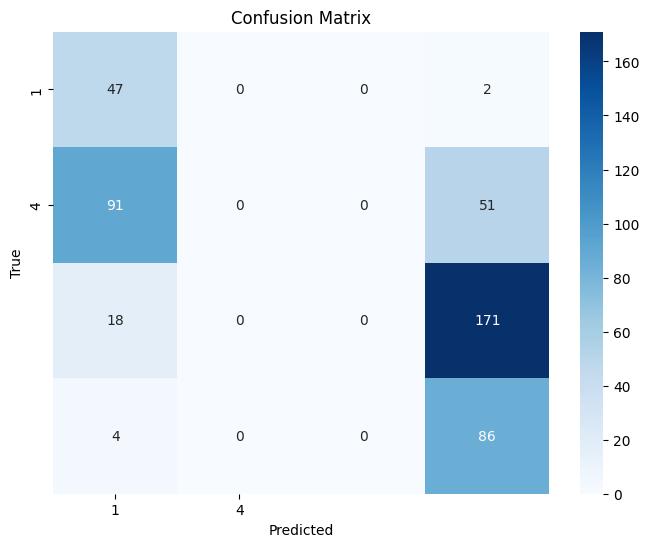

accuracy for class 1: 0.959
accuracy for class 2: 0.000
accuracy for class 3: 0.000
accuracy for class 4: 0.956


In [22]:
points_list = [ 0.99422553,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  3.70749204,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        , -3.32314661, -5.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    0.        , -3.05999037, -5.        ]

threshold = points_list[0]  # threshold for the first feature
points_list = points_list[1:]  # remove the first element which is the threshold

a = 0

sbc = SBC()
sbc_X = data.drop(columns='binary_label')
y = scorecard.train_y_og

# evaluate riskslim model
#predictions, accuracy = evaluate_riskslim_model(points_list, sbc, sbc_X, y, threshold, a=0)

scorecard.evaluate_riskslim_model(points_list, sbc_X, threshold, a)